Based on
https://www.tensorflow.org/tutorials/images/classification

In [9]:
%matplotlib inline

import collections
# import os.path

import cirq
from cirq.contrib.svg import SVGCircuit
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sympy
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_quantum as tfq

Loading the dataset

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop',

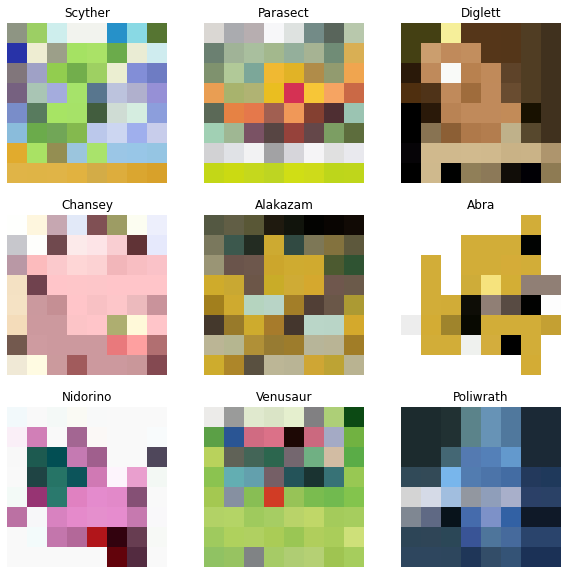

In [10]:
data_dir = "./PokemonData"
split_seed = 123
image_size = (8, 8)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=split_seed,
    image_size=image_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=split_seed,
    image_size=image_size
)
class_names = train_ds.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [18]:
# Performance tuning
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

classical_model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1/255, input_shape=(*image_size, 3)),
    layers.Conv2D(16, 3, padding="same", activation="relu"),
    layers.Flatten(),
    layers.Dense(8, activation="relu"),
    layers.Dense(2)
])

classical_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

classical_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_6 (Rescaling)      (None, 8, 8, 3)           0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 16)          448       
_________________________________________________________________
flatten_6 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                16400     
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 34        
Total params: 16,882
Trainable params: 16,882
Non-trainable params: 0
_________________________________________________________________


In [24]:
class CircuitLayerBuilder:
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(*image_size)
    readout = cirq.GridQubit.rect(8, 1)
    circuit = cirq.Circuit()

    # TODO

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    for qubit in readout:
        circuit.append(cirq.H(qubit))

    return circuit, cirq.Z(readout)

model_circuit, model_readout = create_quantum_model()

SVGCircuit(model_circuit)

TypeError: unhashable type: 'list'

In [22]:
quantum_model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
classical_model.fit(train_ds.)

# TODO